In [10]:
import logging
import os

import gensim
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from rich import print
from utils import get_input_files, view_sample_graph

from tqdm import tqdm


%load_ext rich
%load_ext autoreload
%autoreload 2

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

nltk.download("stopwords")
pd.set_option("display.max_columns", None)
pyLDAvis.enable_notebook()
tqdm.pandas()

The rich extension is already loaded. To reload it, use:
  %reload_ext rich
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to C:\Users\Lakshya
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [2]:
SUBREDDIT_NAME = "google"

### Submissions

In [3]:
submission_columns_ = [
    "author",
    "created_utc",
    "domain",
    "id",
    "is_self",
    "num_comments",
    "score",
    "selftext",
    "subreddit",
    "subreddit_id",
    "subreddit_subscribers",
    "title",
    "url",
    "downs",
    "ups",
]

submissions = get_input_files(SUBREDDIT_NAME, type="submissions").read()[
    submission_columns_
]

submissions = submissions[~submissions["author"].isin(["[deleted]", "[removed]"])]

INFO:DataLoader:File google_submissions.zst already exists


### Comments

In [4]:
comments_columns_ = [
    "body",
    "name",
    "link_id",
    "parent_id",
    "downs",
    "subreddit",
    "score",
    "ups",
    "author",
    "created_utc",
    "permalink",
]


comments = get_input_files(SUBREDDIT_NAME, type="comments").read()[comments_columns_]

comments = comments[~comments["author"].isin(["[deleted]", "[removed]"])]
comments["submission_id"] = comments["link_id"].str.split("t3_").str[1]

INFO:DataLoader:File google_comments.zst already exists


In [5]:
comments

,body,name,link_id,parent_id,downs,subreddit,score,ups,author,created_utc,permalink,submission_id
0,Wow. The effect of cities on the terrain is ....,t1_c03449x,t3_67xq9,t3_67xq9,0.0,google,1,1.0,Prysorra,1202363492,NaN,67xq9
1,How so? Cities are normally built up on low ly...,t1_c0344hs,t3_67xq9,t1_c03449x,0.0,google,1,1.0,unripegreenbanana,1202365216,NaN,67xq9
2,The colors in the Atlanta area do not match to...,t1_c0344j4,t3_67xq9,t1_c0344hs,0.0,google,1,1.0,Prysorra,1202365452,NaN,67xq9
4,For more Google tricks check:\r\nhttp://www.ma...,t1_c0346ul,t3_67ytu,t3_67ytu,0.0,google,1,1.0,hoss-style,1202393345,NaN,67ytu
9,&gt;This way it could browse real businesses t...,t1_c03inif,t3_6d2c2,t3_6d2c2,0.0,google,1,1.0,shopcat,1206290555,NaN,6d2c2
...,...,...,...,...,...,...,...,...,...,...,...,...
740675,"I'm using an Android phone, and will install t...",t1_j2ft6ht,t3_zzce2i,t1_j2cppu5,NaN,google,1,NaN,SamuraiF0X,1672529193,/r/google/comments/zzce2i/premium_giveaway_for...,zzce2i
740676,I actually am seeking help. There was no good ...,t1_j2fty0r,t3_zzlqzb,t1_j2ccict,NaN,google,1,NaN,Technical_Bank1829,1672529537,/r/google/comments/zzlqzb/google_is_saying_unu...,zzlqzb
740677,Your talking about the company who ley there d...,t1_j2fu1zl,t3_zzt1fq,t1_j2fqp61,NaN,google,1,NaN,coolman9110996,1672529586,/r/google/comments/zzt1fq/never_knew_googlecom...,zzt1fq
740678,Lets see the actual certificate returned to th...,t1_j2fuuao,t3_zzt1fq,t3_zzt1fq,NaN,google,4,NaN,ghost-train,1672529939,/r/google/comments/zzt1fq/never_knew_googlecom...,zzt1fq


## Topic modeling

In [6]:
submissions['year'] = pd.to_datetime(submissions['created_utc'], unit='s').dt.year

In [7]:
# Clean submission title
stop_words = stopwords.words("english")
stop_words.extend(["google"])

def clean_post_title(post):
    return " ".join(
        [
            word
            for word in simple_preprocess(post)
            if word not in stop_words and len(word) > 2
        ]
    )

In [8]:
sample = submissions["title"].sample(10, random_state=42).tolist()
print(sample)

sample_cleaned = [clean_post_title(post) for post in sample]
print(sample_cleaned)

[
    'Apply Now for Paid Google Summer Internship 2020 – Monthly Stipend $6000',
    'Prediksi Las Palmas vs Celta De Vigo 17 Oktober 2017',
    'Google Bulletin is the company’s first foray into crowdsourced, hyperlocal news',
    "What does the FCC's new ruling mean for Fiber?",
    'ConvertXtoDVD 4.1.7.343',
    'Facebook Messenger',
    "AJ wants to list Lenny's website on the first page in Google (x-post /r/itslenny)",
    'Yes, F security and privacy.',
    "'Google Now' even started notifying me of price changes of products I searched! Freaks me out",
    'Semantic Search Engine Omnity Claims That It Can Beat Google And Buy It.'
]

[
    'apply paid summer internship monthly stipend',
    'prediksi las palmas celta vigo oktober',
    'bulletin company first foray crowdsourced hyperlocal news',
    'fcc new ruling mean fiber',
    'convertxtodvd',
    'facebook messenger',
    'wants list lenny website first page post itslenny',
    'yes security privacy',
    'even started notifying price changes products searched freaks',
    'semantic search engine omnity claims beat buy'
]

In [9]:
submissions["clean_title"] = submissions["title"].progress_apply(clean_post_title)

In [11]:
submissions

,author,created_utc,domain,id,is_self,num_comments,score,selftext,subreddit,subreddit_id,subreddit_subscribers,title,url,downs,ups,year,clean_title
0,mattevans,1201308801,informationweek.com,66nf3,False,0,6,,google,t5_2qh45,NaN,Google takes aim at domain tasting profiteers,http://www.informationweek.com/management/show...,NaN,NaN,2008,takes aim domain tasting profiteers
1,micahfk,1201803521,googlesearchsucks.com,67997,False,0,1,,google,t5_2qh45,NaN,Google Fails Citizenship Test,http://googlesearchsucks.com/google-fails-citi...,NaN,NaN,2008,fails citizenship test
2,mattevans,1201861278,news.com,67c2h,False,0,3,,google,t5_2qh45,NaN,"At Google, fewer 'Nooglers'",http://www.news.com/8301-10784_3-9862375-7.html,NaN,NaN,2008,fewer nooglers
3,mattevans,1202127332,theregister.co.uk,67le1,False,0,1,,google,t5_2qh45,NaN,Microhoo! marriage hits Google salaries hard,http://www.theregister.co.uk/2008/02/04/google...,NaN,NaN,2008,microhoo marriage hits salaries hard
4,Aaronontheweb,1202355557,techcrunch.com,67xf9,False,0,0,,google,t5_2qh45,NaN,Rumor: Is Google About to Buy Bebo For $1 Bill...,http://www.techcrunch.com/2008/02/06/rumor-is-...,NaN,NaN,2008,rumor buy bebo billion billion myspace
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227773,NikTebow,1672522034,self.google,10043xk,True,1,1,[removed],google,t5_2qh45,2069524.0,School google workspace account being deleted,https://www.reddit.com/r/google/comments/10043...,NaN,NaN,2022,school workspace account deleted
227775,Slow_Art3559,1672522621,mediafire.com,1004bc2,False,0,1,,google,t5_2qh45,2069524.0,Kenny Sletch_Labatsi áudio oficial unpload By ...,https://www.mediafire.com/file/lwbkwhuh4lqm94z...,NaN,NaN,2022,kenny sletch_labatsi áudio oficial unpload blo...
227777,SnarkyPuss,1672525925,self.google,1005f0p,True,2,0,Editing to clarify my post is about Google cal...,google,t5_2qh45,2069524.0,Holidays showing as events on personal calendar,https://www.reddit.com/r/google/comments/1005f...,NaN,NaN,2022,holidays showing events personal calendar
227778,TheGamingHusk,1672528032,self.google,100640t,True,0,1,[removed],google,t5_2qh45,2069524.0,Foreign Account,https://www.reddit.com/r/google/comments/10064...,NaN,NaN,2022,foreign account


In [12]:
titles = submissions['clean_title'].apply(str.split)
id2word = corpora.Dictionary(titles)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary<9536 unique tokens: ['aim', 'domain', 'profiteers', 'takes', 'tasting']...>
INFO:gensim.corpora.dictionary:adding document #20000 to Dictionary<14408 unique tokens: ['aim', 'domain', 'profiteers', 'takes', 'tasting']...>
INFO:gensim.corpora.dictionary:adding document #30000 to Dictionary<18280 unique tokens: ['aim', 'domain', 'profiteers', 'takes', 'tasting']...>
INFO:gensim.corpora.dictionary:adding document #40000 to Dictionary<21772 unique tokens: ['aim', 'domain', 'profiteers', 'takes', 'tasting']...>
INFO:gensim.corpora.dictionary:adding document #50000 to Dictionary<24754 unique tokens: ['aim', 'domain', 'profiteers', 'takes', 'tasting']...>
INFO:gensim.corpora.dictionary:adding document #60000 to Dictionary<28005 unique tokens: ['aim', 'domain', 'profiteers', 'takes', 'tasting']...>
INFO:gensim.corpora.dictionary:adding document

In [13]:
corpus = [id2word.doc2bow(title) for title in titles]

In [24]:
# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    workers=3,
    passes=5,
    iterations=200,
    random_state=42
)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.2
INFO:gensim.models.ldamodel:using symmetric eta at 0.2
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamulticore:running online LDA training, 5 topics, 5 passes over the supplied corpus of 190528 documents, updating every 6000 documents, evaluating every ~60000 documents, iterating 200x with a convergence threshold of 0.001000
INFO:gensim.models.ldamulticore:training LDA model using 3 processes
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/190528, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/190528, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/190528, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/190528, outstanding queue size

In [25]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]


INFO:gensim.models.ldamodel:topic #0 (0.200): 0.025*"new" + 0.019*"chrome" + 0.015*"app" + 0.015*"com" + 0.014*"android" + 0.013*"apple" + 0.011*"store" + 0.010*"https" + 0.009*"play" + 0.008*"youtube"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0.037*"search" + 0.020*"drive" + 0.018*"شماره" + 0.018*"خاله" + 0.012*"photos" + 0.009*"results" + 0.009*"home" + 0.007*"like" + 0.006*"images" + 0.005*"files"
INFO:gensim.models.ldamodel:topic #2 (0.200): 0.024*"buy" + 0.019*"apple" + 0.016*"reviews" + 0.009*"news" + 0.008*"data" + 0.008*"photodollar" + 0.007*"facebook" + 0.007*"amp" + 0.005*"star" + 0.005*"says"
INFO:gensim.models.ldamodel:topic #3 (0.200): 0.026*"account" + 0.023*"help" + 0.015*"gmail" + 0.012*"phone" + 0.012*"get" + 0.011*"know" + 0.011*"anyone" + 0.009*"need" + 0.008*"please" + 0.008*"email"
INFO:gensim.models.ldamodel:topic #4 (0.200): 0.026*"pixel" + 0.025*"bitcoin" + 0.021*"apple" + 0.011*"watch" + 0.010*"best" + 0.009*"online" + 0.009*"free" + 0.007*"iphone" + 0.006*

[
    (
        0,
        '0.025*"new" + 0.019*"chrome" + 0.015*"app" + 0.015*"com" + 0.014*"android" + 0.013*"apple" + 0.011*"store"
+ 0.010*"https" + 0.009*"play" + 0.008*"youtube"'
    ),
    (
        1,
        '0.037*"search" + 0.020*"drive" + 0.018*"شماره" + 0.018*"خاله" + 0.012*"photos" + 0.009*"results" + 
0.009*"home" + 0.007*"like" + 0.006*"images" + 0.005*"files"'
    ),
    (
        2,
        '0.024*"buy" + 0.019*"apple" + 0.016*"reviews" + 0.009*"news" + 0.008*"data" + 0.008*"photodollar" + 
0.007*"facebook" + 0.007*"amp" + 0.005*"star" + 0.005*"says"'
    ),
    (
        3,
        '0.026*"account" + 0.023*"help" + 0.015*"gmail" + 0.012*"phone" + 0.012*"get" + 0.011*"know" + 
0.011*"anyone" + 0.009*"need" + 0.008*"please" + 0.008*"email"'
    ),
    (
        4,
        '0.026*"pixel" + 0.025*"bitcoin" + 0.021*"apple" + 0.011*"watch" + 0.010*"best" + 0.009*"online" + 
0.009*"free" + 0.007*"iphone" + 0.006*"love" + 0.006*"pro"'
    )
]

In [27]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(
    topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.250256  0.038951       1        1  24.739296
0      0.004600 -0.120558       2        1  21.113546
1     -0.173429 -0.026494       3        1  19.074715
4      0.247424 -0.169599       4        1  17.635468
2      0.171661  0.277700       5        1  17.436976,
    topic_info=           Term         Freq        Total Category  logprob  loglift
34       search  7981.000000  7981.000000  Default  30.0000  30.0000
287     account  7140.000000  7140.000000  Default  29.0000  29.0000
13310     pixel  5168.000000  5168.000000  Default  28.0000  28.0000
650        help  6375.000000  6375.000000  Default  27.0000  27.0000
14124   bitcoin  4857.000000  4857.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
283        says   883.722801  1562.311223   Topic5  -5.4015   1.1768
798     support   722.049252  2025.180816   Topic5  -5.6035   0.7153
320        tech   660.551782  2213.940748   Topic5  -5.6925   0.5371
1077    content   585.598576  1090.335776   Topic5  -5.8130   1.1250
266    business   573.635032  1933.481390   Topic5  -5.8336   0.5315

[307 rows x 6 columns],
    token_table=       Topic      Freq      Term
term                            
199        1  0.990324    access
199        5  0.009124    access
287        1  0.999820   account
287        5  0.000140   account
795        1  0.999716  accounts
...      ...       ...       ...
378        3  0.191275   youtube
378        5  0.003032   youtube
53885      3  0.996102     تهران
55678      3  0.999669      خاله
54152      3  0.999727     شماره

[532 rows x 3 columns],
    R=30,
    lambda_step=0.01,
    plot_opts={'xlab': 'PC1', 'ylab': 'PC2'},
    topic_order=[4, 1, 2, 5, 3]
)

In [26]:
topic_words = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)

print(topic_words)

[
    (
        0,
        [
            ('new', 0.024760135),
            ('chrome', 0.01884368),
            ('app', 0.015252803),
            ('com', 0.0150991725),
            ('android', 0.014409258),
            ('apple', 0.012855144),
            ('store', 0.011036624),
            ('https', 0.009635804),
            ('play', 0.008982604),
            ('youtube', 0.007615695)
        ]
    ),
    (
        1,
        [
            ('search', 0.037123468),
            ('drive', 0.01967984),
            ('شماره', 0.017705623),
            ('خاله', 0.017529316),
            ('photos', 0.0120203765),
            ('results', 0.009044612),
            ('home', 0.008711619),
            ('like', 0.0069283927),
            ('images', 0.005643906),
            ('files', 0.005435729)
        ]
    ),
    (
        2,
        [
            ('buy', 0.02372605),
            ('apple', 0.019255217),
            ('reviews', 0.016062066),
            ('news', 0.009217979),
            ('data', 0.007889993),
            ('photodollar', 0.0076724207),
            ('facebook', 0.0074469615),
            ('amp', 0.0072863647),
            ('star', 0.0046917996),
            ('says', 0.004509954)
        ]
    ),
    (
        3,
        [
            ('account', 0.025679547),
            ('help', 0.022929773),
            ('gmail', 0.015129612),
            ('phone', 0.012378037),
            ('get', 0.011553234),
            ('know', 0.011050839),
            ('anyone', 0.010585864),
            ('need', 0.0093526235),
            ('please', 0.008335243),
            ('email', 0.007714249)
        ]
    ),
    (
        4,
        [
            ('pixel', 0.026071278),
            ('bitcoin', 0.02450733),
            ('apple', 0.021318737),
            ('watch', 0.010700607),
            ('best', 0.0095051555),
            ('online', 0.009142347),
            ('free', 0.008939832),
            ('iphone', 0.0069125276),
            ('love', 0.00644497),
            ('pro', 0.0062635783)
        ]
    )
]

### Topic Summaries

#### Topic 0: Google products and services
  Keywords: "chrome", "android", "play", "youtube", "app"
  
  Summary: Focuses on Google's various products and services, highlighting mobile applications and platforms like Google Play Store.

#### Topic 1: Search and cloud storage
  Keywords: "search", "drive", "photos", "results", "files"
  
  Summary: Centers on Google's search capabilities and cloud storage solutions, specifically Google Drive and Google Photos.

#### Topic 2: Tech company news and reviews
  Keywords: "apple", "news", "facebook", "reviews", "data", "says"
  
  Summary: Captures discussions and news about major tech companies, comparing products and data practices among giants like Apple and Facebook.

#### Topic 3: Account support and troubleshooting
  Keywords: "account", "help", "gmail", "phone", "email", "need", "please"
  
  Summary: Relates to user support for Google accounts and services, with a strong emphasis on Gmail troubleshooting.

#### Topic 4: Hardware products
  Keywords: "pixel", "apple", "watch", "iphone", "pro"
  
  Summary: Discusses hardware products, comparing features, pricing, and reviews of items like Pixel phones, Apple Watch, and iPhones.

In [28]:
topic_names = {
    0: "Google products and services",
    1: "Search and cloud storage",
    2: "Tech company news and reviews",
    3: "Account support and troubleshooting",
    4: "Hardware products",
}

In [29]:
# Assign submission to topic
def assign_topic(lda_model, corpus, topic_interpretation):
    """
    Assigns a topic to each submission based on the topic with the highest probability

    :param lda_model: LDA model
    :param corpus: corpus
    :param topic_interpretation: dictionary with topic interpretation (e.g. {0: 'topic1', 1: 'topic2'})
    """
    doc_lda = lda_model[corpus]
    topics = [max(doc, key=lambda x: x[1])[0] for doc in doc_lda]
    return [topic_interpretation[topic] for topic in topics]


submissions["topic"] = assign_topic(lda_model, corpus, topic_names)

submissions

,author,created_utc,domain,id,is_self,num_comments,score,selftext,subreddit,subreddit_id,subreddit_subscribers,title,url,downs,ups,year,clean_title,topic
0,mattevans,1201308801,informationweek.com,66nf3,False,0,6,,google,t5_2qh45,NaN,Google takes aim at domain tasting profiteers,http://www.informationweek.com/management/show...,NaN,NaN,2008,takes aim domain tasting profiteers,Hardware products
1,micahfk,1201803521,googlesearchsucks.com,67997,False,0,1,,google,t5_2qh45,NaN,Google Fails Citizenship Test,http://googlesearchsucks.com/google-fails-citi...,NaN,NaN,2008,fails citizenship test,Search and cloud storage
2,mattevans,1201861278,news.com,67c2h,False,0,3,,google,t5_2qh45,NaN,"At Google, fewer 'Nooglers'",http://www.news.com/8301-10784_3-9862375-7.html,NaN,NaN,2008,fewer nooglers,Search and cloud storage
3,mattevans,1202127332,theregister.co.uk,67le1,False,0,1,,google,t5_2qh45,NaN,Microhoo! marriage hits Google salaries hard,http://www.theregister.co.uk/2008/02/04/google...,NaN,NaN,2008,microhoo marriage hits salaries hard,Tech company news and reviews
4,Aaronontheweb,1202355557,techcrunch.com,67xf9,False,0,0,,google,t5_2qh45,NaN,Rumor: Is Google About to Buy Bebo For $1 Bill...,http://www.techcrunch.com/2008/02/06/rumor-is-...,NaN,NaN,2008,rumor buy bebo billion billion myspace,Tech company news and reviews
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227773,NikTebow,1672522034,self.google,10043xk,True,1,1,[removed],google,t5_2qh45,2069524.0,School google workspace account being deleted,https://www.reddit.com/r/google/comments/10043...,NaN,NaN,2022,school workspace account deleted,Account support and troubleshooting
227775,Slow_Art3559,1672522621,mediafire.com,1004bc2,False,0,1,,google,t5_2qh45,2069524.0,Kenny Sletch_Labatsi áudio oficial unpload By ...,https://www.mediafire.com/file/lwbkwhuh4lqm94z...,NaN,NaN,2022,kenny sletch_labatsi áudio oficial unpload blo...,Account support and troubleshooting
227777,SnarkyPuss,1672525925,self.google,1005f0p,True,2,0,Editing to clarify my post is about Google cal...,google,t5_2qh45,2069524.0,Holidays showing as events on personal calendar,https://www.reddit.com/r/google/comments/1005f...,NaN,NaN,2022,holidays showing events personal calendar,Account support and troubleshooting
227778,TheGamingHusk,1672528032,self.google,100640t,True,0,1,[removed],google,t5_2qh45,2069524.0,Foreign Account,https://www.reddit.com/r/google/comments/10064...,NaN,NaN,2022,foreign account,Account support and troubleshooting


In [36]:
SELECTED_TOPIC = topic_names[0]

submission_t = submissions[submissions["topic"] == SELECTED_TOPIC]
comments_t = comments[comments["submission_id"].isin(submission_t["id"])]


In [74]:
comments_t

,body,name,link_id,parent_id,downs,subreddit,score,ups,author,created_utc,permalink,submission_id
10,Mirror?\n\n&gt; 404 Error - Page Cannot Be Fou...,t1_c03jzqh,t3_6djmy,t3_6djmy,0.0,google,2,2.0,jayssite,1206631249,NaN,6djmy
11,I guess [this](http://www.google.co.in/search?...,t1_c03k1oc,t3_6djmy,t1_c03jzqh,0.0,google,0,0.0,vardhan,1206639855,NaN,6djmy
12,"When google.com also has animated icons, we kn...",t1_c03kook,t3_6dt2i,t3_6dt2i,0.0,google,2,2.0,MarkByers,1206802554,NaN,6dt2i
13,[Richard Branson](http://www.youtube.com/watch...,t1_c03ljd1,t3_6e5el,t3_6e5el,0.0,google,3,3.0,sheeep,1207048475,NaN,6e5el
14,And I hear they still have [some old jobs avai...,t1_c03ljnl,t3_6e5el,t3_6e5el,0.0,google,2,2.0,mattevans,1207052062,NaN,6e5el
...,...,...,...,...,...,...,...,...,...,...,...,...
740603,Agreed! I mostly listen on the phone so do not...,t1_j2e41hm,t3_zz4f3g,t1_j29yxm8,NaN,google,1,NaN,tikkamasalaicecoffee,1672503218,/r/google/comments/zz4f3g/the_podcast_app/j2e4...,zz4f3g
740653,r/lostredditors,t1_j2eycf1,t3_zzmgvr,t3_zzmgvr,NaN,google,3,NaN,membershipreward,1672515554,/r/google/comments/zzmgvr/the_bermuda_triangle...,zzmgvr
740659,Pocket Casts syncing is one reason I'm conside...,t1_j2f2lvk,t3_zz4f3g,t1_j29yxm8,NaN,google,1,NaN,sofatheologe,1672517369,/r/google/comments/zz4f3g/the_podcast_app/j2f2...,zz4f3g
740661,I've been wondering for a while now if Google ...,t1_j2f2v75,t3_zz4f3g,t3_zz4f3g,NaN,google,1,NaN,sofatheologe,1672517483,/r/google/comments/zz4f3g/the_podcast_app/j2f2...,zz4f3g


In [86]:
user_weights = (
    comments_t.groupby("author")
    .agg({"score": "mean", "body": "count"})
    .rename(columns={"score": "average_score", "body": "num_comments"})
    .sort_values(by=["num_comments", "average_score"], ascending=False)
)

user_weights


,average_score,num_comments
author,,
AutoModerator,0.996760,2778
bartturner,2.966012,1324
aesamattki,2.856655,293
dnew,2.959350,246
Lobanium,5.407725,233
...,...,...
barcap,-58.000000,1
iBSHA_,-60.000000,1
slayerofgods615,-63.000000,1


In [37]:
# Top users by number of comments
comments_t.groupby("author")["submission_id"].count().sort_values(ascending=False).head(
    10
)



author
AutoModerator         2778
bartturner            1324
aesamattki             293
dnew                   246
Lobanium               233
port53                 195
JamesR624              193
ElMax-                 192
doireallyneedone11     182
koavf                  180
Name: submission_id, dtype: int64

## Create bipartite graph

In [109]:
def create_bipartite_graph(df: pd.DataFrame):
    B = nx.Graph()

    users = df["author"].unique()
    posts = df["link_id"].unique()

    B.add_nodes_from(users, bipartite=0)
    B.add_nodes_from(posts, bipartite=1)

    edges = [
        (row["author"], row["link_id"], row["score"]) for index, row in df.iterrows()
    ]

    B.add_weighted_edges_from(edges)

    if nx.is_bipartite(B):
        user_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
        post_nodes = set(B) - user_nodes

    return user_nodes, post_nodes, B


def project_bipartite_graph(B, nodes):
    return nx.bipartite.weighted_projected_graph(B, nodes)


In [110]:
user_nodes_t, post_nodes_t, B_t = create_bipartite_graph(comments_t)

G_user_t = project_bipartite_graph(B_t, user_nodes_t)

In [112]:
list(G_user_t.edges(data=True))[45:50]


[
    ('SanityInAnarchy', 'CrowGrandFather', {'weight': 1}),
    ('SanityInAnarchy', 'joaodiogotim', {'weight': 1}),
    ('SanityInAnarchy', 'E06SP', {'weight': 1}),
    ('SanityInAnarchy', 'jdfertig', {'weight': 1}),
    ('SanityInAnarchy', 'supasteve013', {'weight': 1})
]

In [113]:
len(G_user_t.nodes), len(G_user_t.edges)

(43222, 1702980)

### Add node attributes

In [114]:
user_weights

,average_score,num_comments
author,,
AutoModerator,0.996760,2778
bartturner,2.966012,1324
aesamattki,2.856655,293
dnew,2.959350,246
Lobanium,5.407725,233
...,...,...
barcap,-58.000000,1
iBSHA_,-60.000000,1
slayerofgods615,-63.000000,1


In [115]:
for attribute in user_weights.columns:
    nx.set_node_attributes(
        G_user_t,
        pd.Series(user_weights[attribute], index=user_weights.index).to_dict(),
        attribute,
    )

In [116]:
largest_cc_t = max(nx.connected_components(G_user_t), key=len)
G_largest_cc_t = G_user_t.subgraph(largest_cc_t)

In [117]:
len(G_largest_cc_t.nodes), len(G_largest_cc_t.edges)

(40367, 1700705)

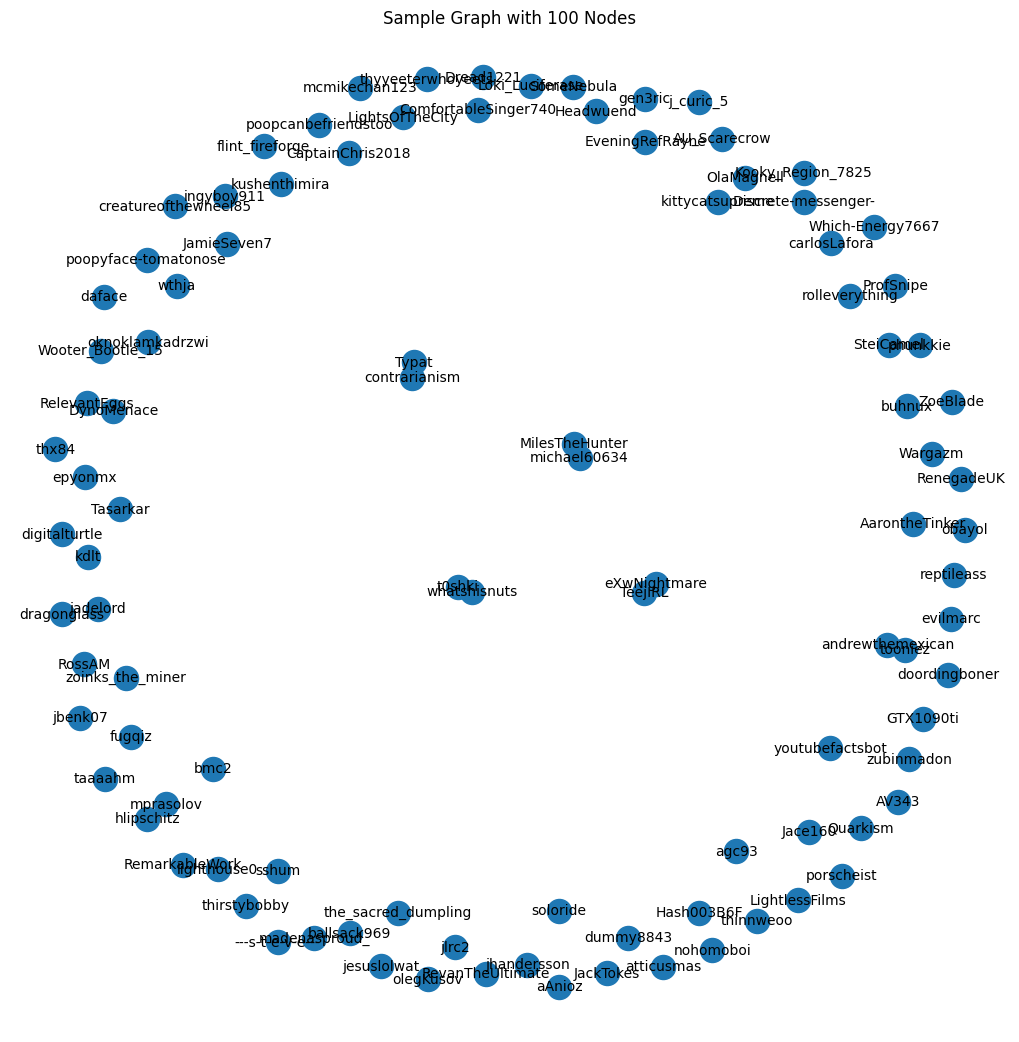

In [118]:
view_sample_graph(G_largest_cc_t, 100)

In [119]:
# View edge attributes for a sample of the graph
sample_edges = list(G_largest_cc_t.edges(data=True))[:5]
print("Sample edge attributes:", sample_edges)


Sample edge attributes:
[
    ('reptileass', 'q00u', {'weight': 1}),
    ('reptileass', 'PaintDrinkingPete', {'weight': 1}),
    ('reptileass', '1thief', {'weight': 1}),
    ('reptileass', 'my_name_isnt_clever', {'weight': 1}),
    ('reptileass', 'CWeaver34', {'weight': 1})
]

In [121]:
nx.write_gexf(G_largest_cc_t, f"{SUBREDDIT_NAME}_{topic_names[0]}_graph.gexf")

In [128]:
degree_centrality = pd.DataFrame(degree_centrality.items(), columns=["author", "degree_centrality"]).sort_values(
    by='degree_centrality', ascending=False
)